In [1]:
import os
import sys
import platform
from pandas.plotting import autocorrelation_plot

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm

from pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA

import itertools
import xgboost as xgb

In [2]:
%matplotlib inline

# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'22', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}
axis_font = {'fontname':'Arial', 'size':'20'}

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [3]:
craig_root_eugene = '/Users/eugeneolkhovik/python_files/ML/climate_data/daily_climate'
craig_root_vlad = ''
filename = 'archive/DailyDelhiClimateTrain.csv'

if platform.system() == 'Darwin':
    csv_file_path = os.path.join(craig_root_eugene, filename)
else:
    csv_file_path = os.path.join(craig_root_vlad, filename)

raw_df = pd.read_csv(csv_file_path,header=0, index_col=0, parse_dates=True, squeeze=True)
raw_df = raw_df[:-1]

In [4]:
raw_df.head()

meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-01  10.000000  84.500000    0.000000   1015.666667
2013-01-02   7.400000  92.000000    2.980000   1017.800000
2013-01-03   7.166667  87.000000    4.633333   1018.666667
2013-01-04   8.666667  71.333333    1.233333   1017.166667
2013-01-05   6.000000  86.833333    3.700000   1016.500000

In [5]:
raw_df.describe()

meantemp     humidity   wind_speed  meanpressure
count  1461.000000  1461.000000  1461.000000   1461.000000
mean     25.506127    60.744851     6.806865   1011.101197
std       7.339416    16.743928     4.559688    180.293335
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.571429
50%      27.714286    62.625000     6.250000   1008.555556
75%      31.312500    72.125000     9.250000   1014.937500
max      38.714286    98.000000    42.220000   7679.333333

In [6]:
raw_df.isna().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

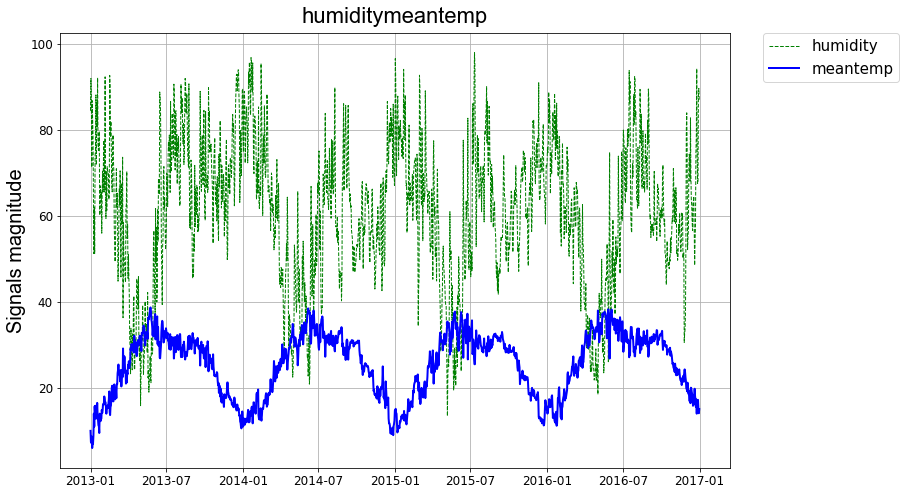

In [7]:
def plot_signals(df, columns):

    s1 = df[columns[0]]
    s2 = df[columns[1]]

    fig = plt.figure()
    fig.set_size_inches(12, 8)
    plt.grid(True)

    plt.plot( s1, label=columns[0], color='g', linestyle="--", linewidth=1)
    plt.plot( s2, label=columns[1], color='b', linestyle="-", linewidth=2)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 15})

    plt.ylabel("Signals magnitude", **axis_font)
    plt.title(columns[0] + columns[1], **title_font)
    plt.show()


plot_signals(raw_df, ['humidity', 'meantemp'])

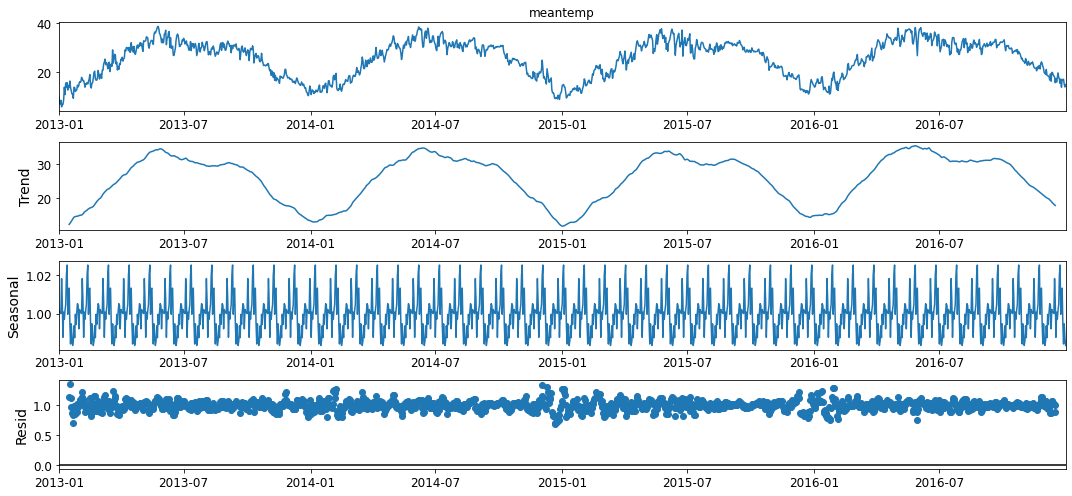

In [8]:
result_mul = sm.tsa.seasonal_decompose(raw_df['meantemp'], model='multiplicative', two_sided = True, freq = 30)
rcParams['figure.figsize'] = 15, 7
fig = result_mul.plot()
plt.show()

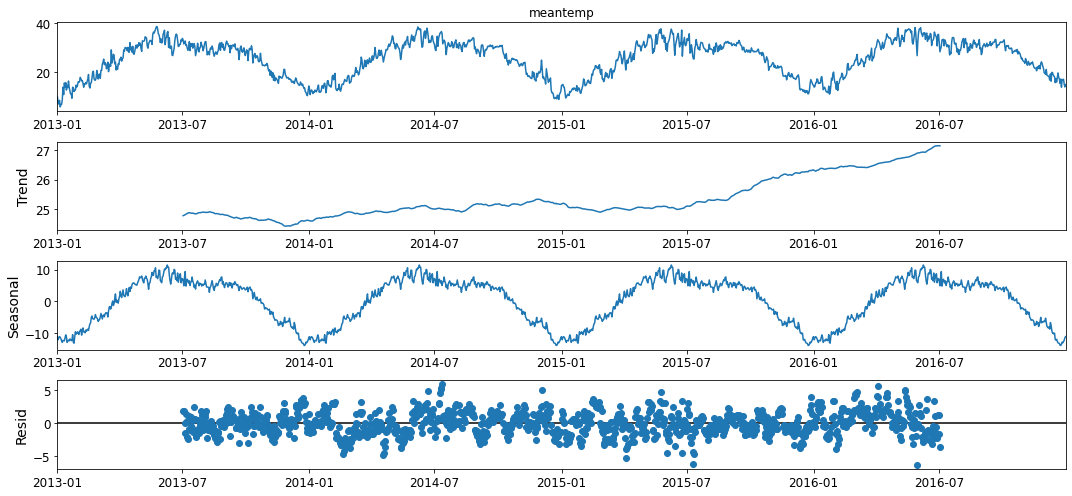

In [9]:
result_add = sm.tsa.seasonal_decompose(raw_df['meantemp'], model='addictive', two_sided = True, freq =365)
rcParams['figure.figsize'] = 15, 7
fig = result_add.plot()
plt.show()

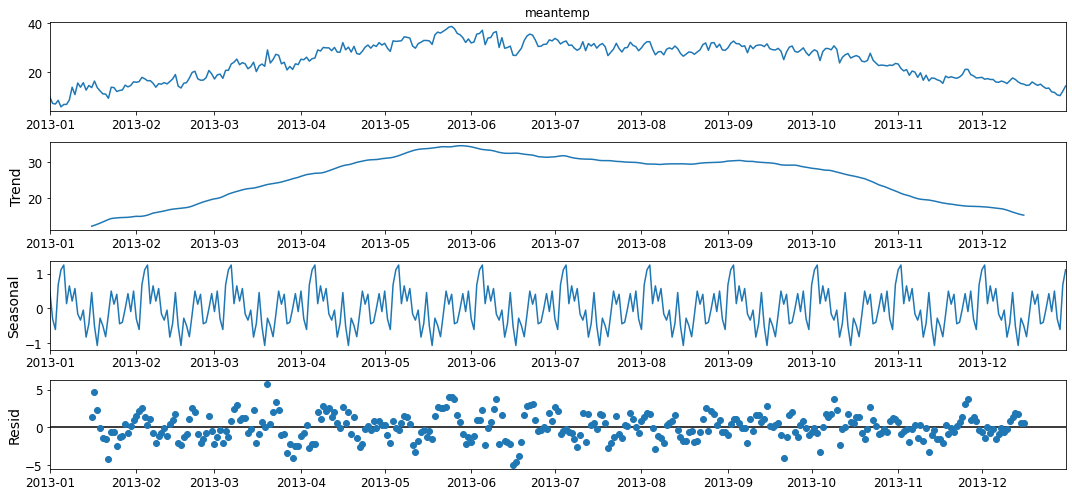

In [10]:
result_add = sm.tsa.seasonal_decompose(raw_df[raw_df.index.year == 2013]['meantemp'], model='addictive', two_sided = True, freq =30)
rcParams['figure.figsize'] = 15, 7
fig = result_add.plot()
plt.show()

In [11]:
raw_df.index.year.unique()[:-1]

Int64Index([2013, 2014, 2015], dtype='int64', name='date')

In [12]:
def boxplots_monthly_year(df, param):
    fig, axes = plt.subplots(4,1)
    fig.set_size_inches((17,17))
    for i, year in enumerate(raw_df.index.year.unique()[:-1]):
        sns.boxplot(x=df[df.index.year ==year].index.month, y=param,data=df[df.index.year ==year],ax=axes[i])
        axes[i].set_ylim([min(df[param]), max(df[param])])
        axes[i].set_title(year)

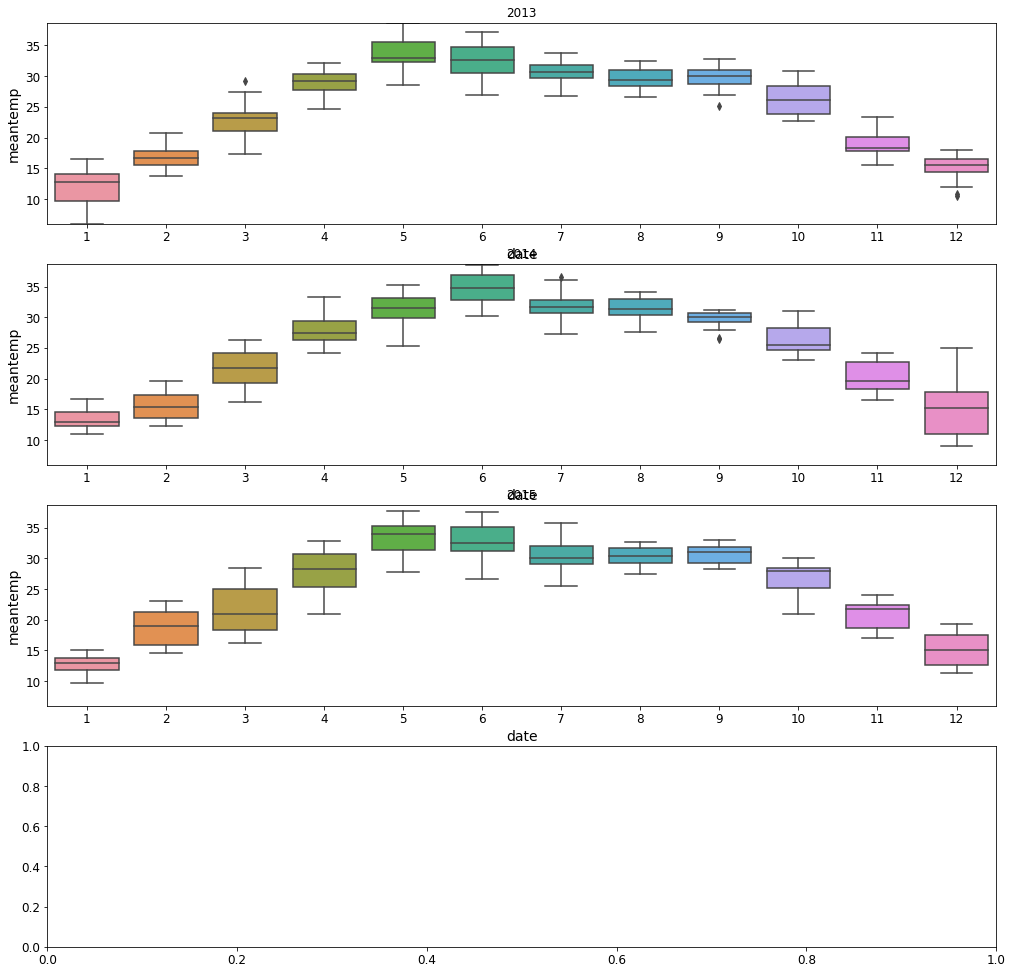

In [13]:
boxplots_monthly_year(raw_df,'meantemp')

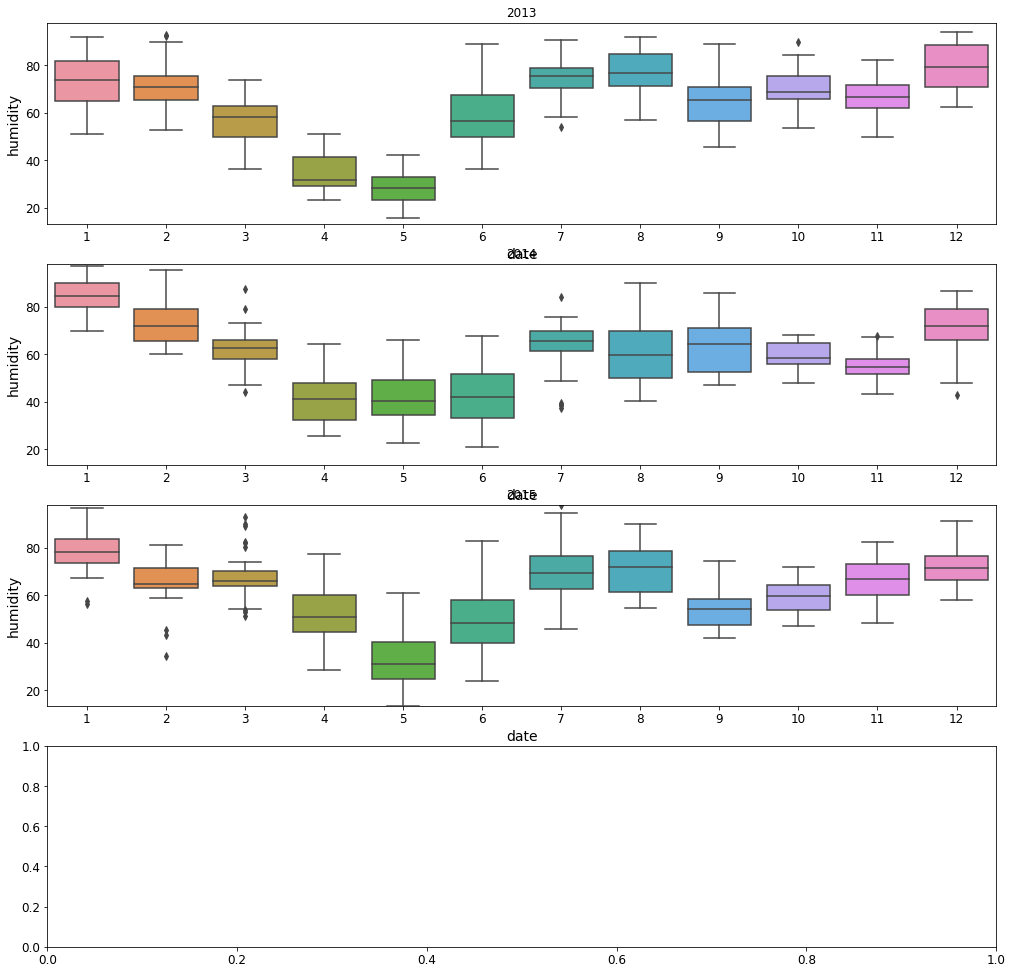

In [14]:
boxplots_monthly_year(raw_df,'humidity')

In [15]:
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

seas  trend  resid  actual_values
date                                             
2013-01-01  0.497468    NaN    NaN      10.000000
2013-01-02 -0.302514    NaN    NaN       7.400000
2013-01-03 -0.606446    NaN    NaN       7.166667
2013-01-04  0.679881    NaN    NaN       8.666667
2013-01-05  1.108074    NaN    NaN       6.000000

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

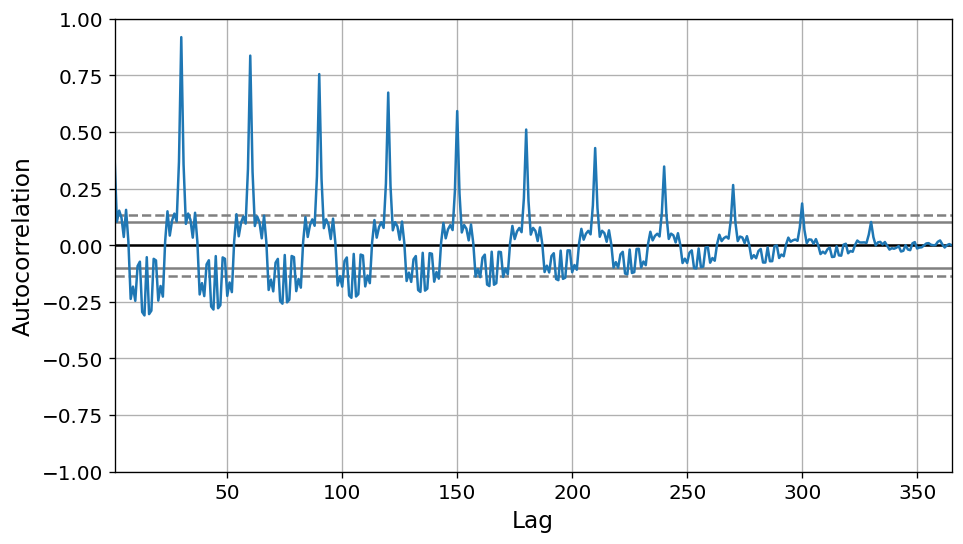

In [16]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df_reconstructed[df_reconstructed.index.year == 2013].seas.tolist())

## SARIMAX

In [17]:
mean_temp = raw_df['meantemp']
raw_df = raw_df.drop(columns = ['meantemp'])

In [18]:
model = sm.tsa.statespace.SARIMAX(endog = mean_temp,exog = raw_df, order=(5,2,0))
results = model.fit(disp=-1)

/Applications/anaconda_python/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Applications/anaconda_python/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [19]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1461
Model:               SARIMAX(5, 2, 0)   Log Likelihood               -2522.699
Date:                Mon, 10 May 2021   AIC                           5063.399
Time:                        22:02:19   BIC                           5110.968
Sample:                    01-01-2013   HQIC                          5081.145
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
humidity        -0.1383      0.003    -41.222      0.000      -0.145      -0.132
wind_speed      -0.0278      0.006     -4.287      0.000      -0.041      -0.015
meanpressure -3.769e-05      0.000     -0.16

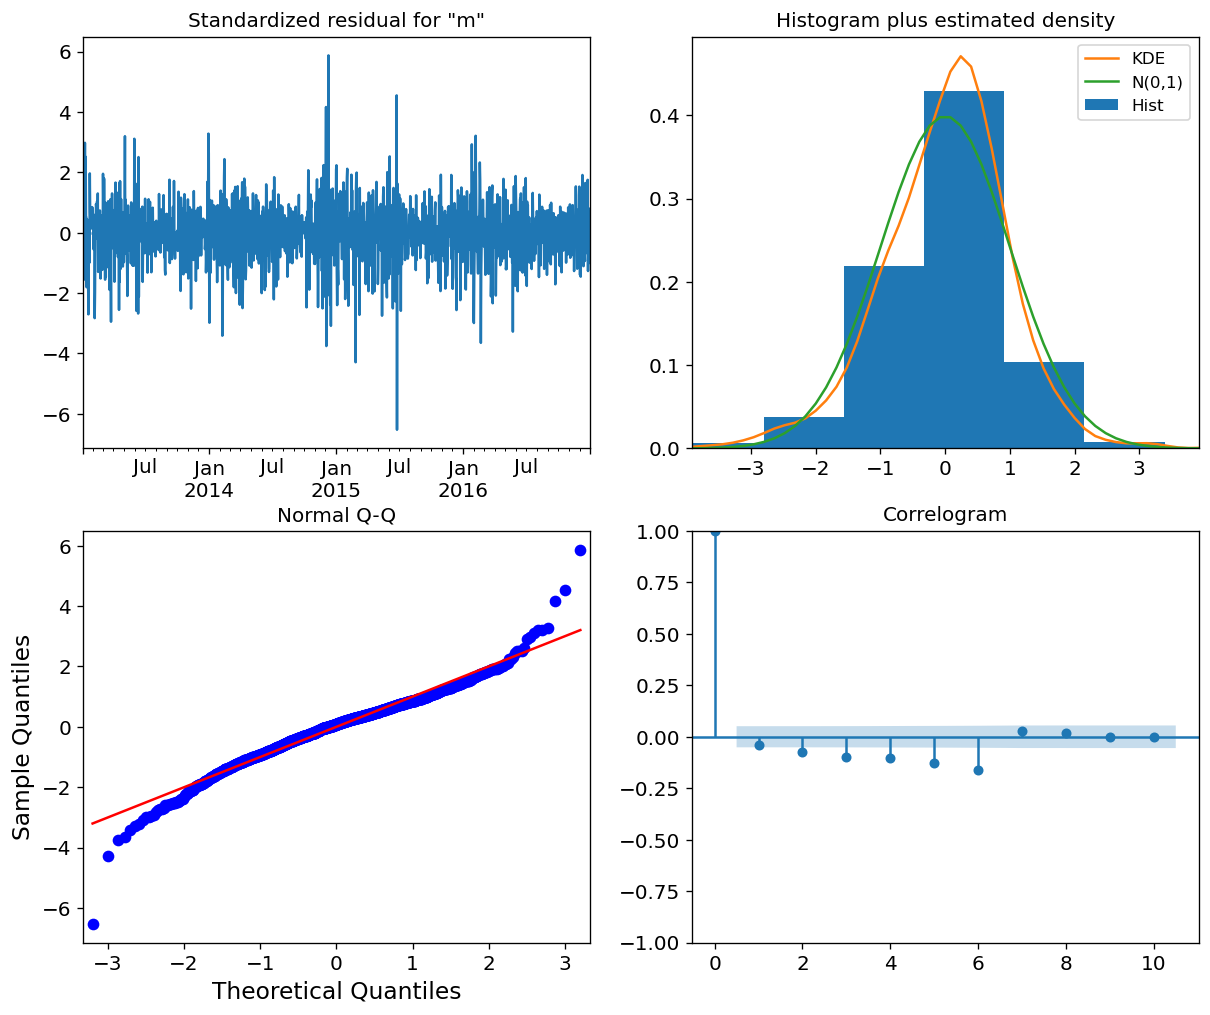

In [20]:
results.plot_diagnostics(figsize=(12, 10))
plt.show()

In [21]:
pred = results.get_prediction(start=pd.to_datetime('2013-01-01'), dynamic=False)
pred_ci = pred.conf_int()

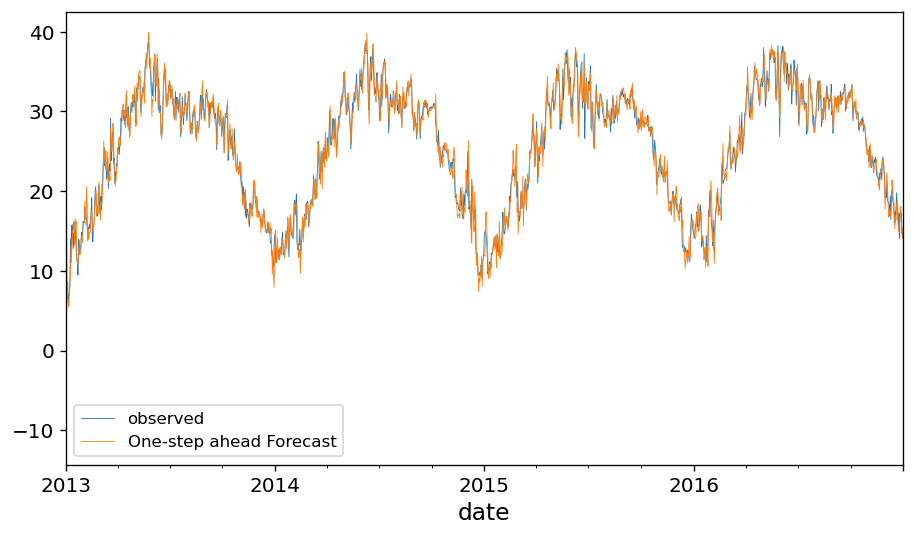

In [22]:
plt.figsize=(30, 10)
ax = mean_temp.plot(label='observed',linewidth=0.5)
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', linewidth=0.5)
plt.legend()
plt.show()

## predict 

In [23]:
test_file = 'archive/DailyDelhiClimateTest.csv'

if platform.system() == 'Darwin':
    csv_file_path = os.path.join(craig_root_eugene, test_file)
else:
    csv_file_path = os.path.join(craig_root_vlad, test_file)

test = pd.read_csv(csv_file_path,header=0, index_col=0, parse_dates=True, squeeze=True)

In [24]:
raw_df

humidity  wind_speed  meanpressure
date                                           
2013-01-01  84.500000    0.000000   1015.666667
2013-01-02  92.000000    2.980000   1017.800000
2013-01-03  87.000000    4.633333   1018.666667
2013-01-04  71.333333    1.233333   1017.166667
2013-01-05  86.833333    3.700000   1016.500000
...               ...         ...           ...
2016-12-27  67.550000    8.335000   1017.200000
2016-12-28  68.043478    3.547826   1015.565217
2016-12-29  87.857143    6.000000   1016.904762
2016-12-30  89.666667    6.266667   1017.904762
2016-12-31  87.000000    7.325000   1016.100000

[1461 rows x 3 columns]

In [25]:
mean_temp_test = test['meantemp']
test = test.drop(columns = ['meantemp'])

In [26]:
pred_uc = results.predict(exog = test,start=pd.to_datetime('2017-01-01'),end=pd.to_datetime('2017-04-24'),dynamic=True)

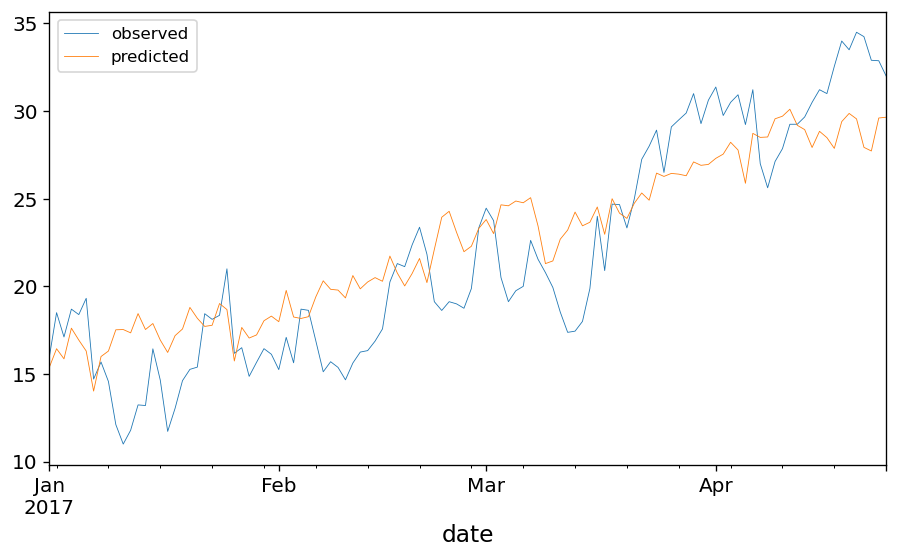

In [49]:
plt.figsize=(30, 10)
#plt.plot(mean_temp_test,linewidth=0.8, lable = 'predicted')
#plt.plot(pred_uc,linewidth=0.8, lable = 'observed')

ax = mean_temp_test.plot(label='observed',linewidth=0.5)
pred_uc.plot(ax=ax, label='predicted', linewidth=0.5)
plt.legend()

plt.show()


In [37]:
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller

X = raw_df['humidity'].values
result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.675577
p-value: 0.004470
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [38]:
df = raw_df[['humidity']]

df['year'] = df.index.year.values
# df.index.year.to_series().values
df[['humidity', 'year']].groupby('year').mean().idxmin().values[0]

2016

In [39]:
df[['humidity', 'year']].groupby('year').agg(new_col1_name=('humidity', 'mean'),
                                             new_col2_name=('humidity', 'count'))


new_col1_name  new_col2_name
year                              
2013      63.046292            365
2014      59.767942            365
2015      61.430490            365
2016      58.740174            366
2017     100.000000              1

In [40]:
df[['humidity', 'year']].groupby('year').agg(['min', 'max', 'mean'])

humidity                        
             min         max        mean
year                                    
2013   15.857143   94.000000   63.046292
2014   20.875000   96.857143   59.767942
2015   13.428571   98.000000   61.430490
2016   18.466667   94.300000   58.740174
2017  100.000000  100.000000  100.000000

In [41]:
raw_df = pd.read_csv('archive/DailyDelhiClimateTrain.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# raw_df = raw_df.resample('M').mean()
raw_df

meantemp    humidity  wind_speed  meanpressure
date                                                       
2013-01-01  10.000000   84.500000    0.000000   1015.666667
2013-01-02   7.400000   92.000000    2.980000   1017.800000
2013-01-03   7.166667   87.000000    4.633333   1018.666667
2013-01-04   8.666667   71.333333    1.233333   1017.166667
2013-01-05   6.000000   86.833333    3.700000   1016.500000
...               ...         ...         ...           ...
2016-12-28  17.217391   68.043478    3.547826   1015.565217
2016-12-29  15.238095   87.857143    6.000000   1016.904762
2016-12-30  14.095238   89.666667    6.266667   1017.904762
2016-12-31  15.052632   87.000000    7.325000   1016.100000
2017-01-01  10.000000  100.000000    0.000000   1016.000000

[1462 rows x 4 columns]

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

X = raw_df['humidity'].values
result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.675577
p-value: 0.004470
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


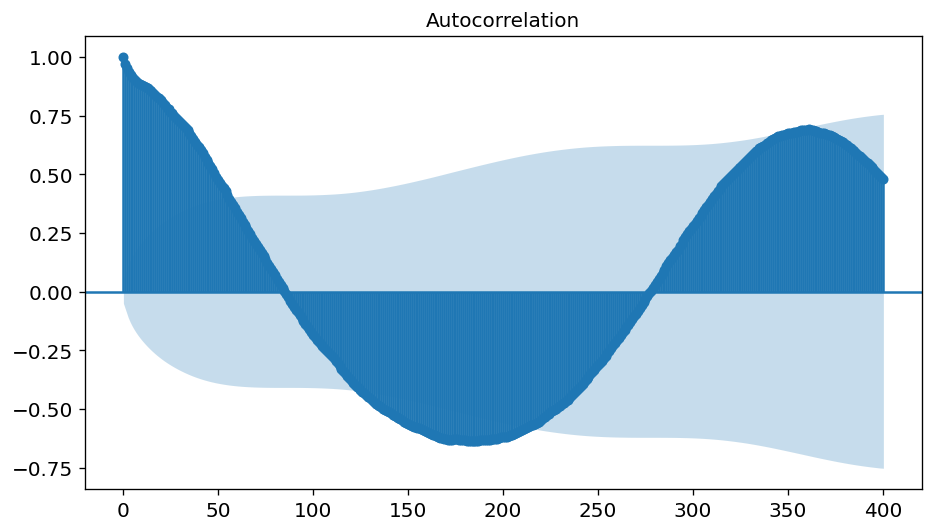

In [43]:
acf_plot = plot_acf(raw_df['meantemp'], lags=400)

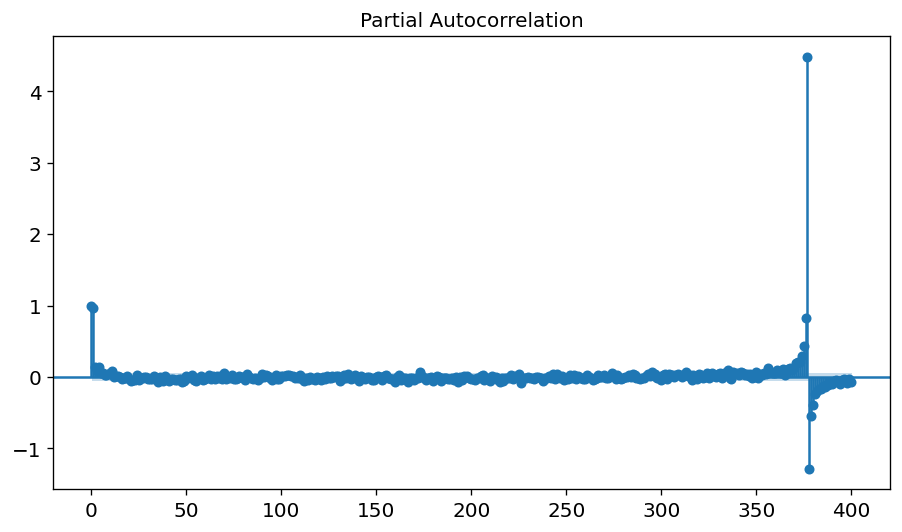

In [44]:
pacf_plot = plot_pacf(raw_df['meantemp'], lags=400)